# An Minimal Example for MCMCDebugging.jl

We start by defining a Beta-Binomial model, two posterior samplers (one bug-free and one buggy) and a test function to use.

In [1]:
using Distributions, DynamicPPL

# The marginal-conditional simulator defined by DynamicPPL
# See README.md for the expected form of the model definition.
@model function BetaBinomial(θ=missing, x=missing)
    θ ~ Beta(2, 3)
    x ~ Binomial(3, θ)
    return θ, x
end

# The successive-conditional simulator
# 1. Bug-free posterior sampler
# Beta(α + x, β + n - x) is the true posterior.
rand_θ_given(x) = rand(Beta(2 + x, 3 + 3 - x))
# 2. Buggy posterior sampler
rand_θ_given_buggy(x) = rand_θ_given(min(3, x + 1))

# Test function
g(θ, x) = cat(θ, x; dims=1)

g (generic function with 1 method)

We firstly perform Geweke test for the bug-free sampler.

In [2]:
using MCMCDebugging

res = perform(GewekeTest(5_000), BetaBinomial, rand_θ_given; g=g)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 5000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: [1.0069391903102192, 0.46797362344774]
    P-value: [0.3139639974176164, 0.6398034522528347]


The p-values look reasonably large ($\geq0.1$).

We can also visualise the result via the Q-Q plot. Plotting functionality is supported via Plots.jl.

Quantile error: 0.003602000000000002


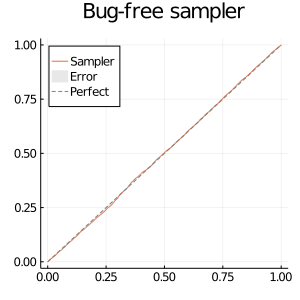

In [3]:
using Plots

plot(res, BetaBinomial(); size=(300, 300), title="Bug-free sampler")

Let's try Geweke test on the buggy sampler now.

In [4]:
res_buggy = perform(GewekeTest(5_000), BetaBinomial, rand_θ_given_buggy)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Test function `g` is not provided. Statistic is not computed.
└ @ MCMCDebugging /Users/kai/projects/TuringLang/MCMCDebugging.jl/src/geweke.jl:77


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 5000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: missing
    P-value: missing

Test statistic is missing. Please use `compute_statistic!(res, g)` 
if you want compute statistic without rerun the simulation.



Oops -- I also didn't passing the testing function `g`, which is wanted if we only want to make the Q-Q plot. But for the statistics and p-values, let's follow the recommendation to update the result.

In [5]:
compute_statistic!(res_buggy, g)

Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 5000
    Parameter dimension: 1
    Data dimension: 1
    Statistic: [-41.00888978073274, -24.577724389227683]
    P-value: [0.0, 2.186427127224003e-133]


The p-values are much smaller, indicating there is strong evidence against the hypothesis that the sampler is bug-free.

Notably, the visualization is also very informative.

Quantile error: 0.157802


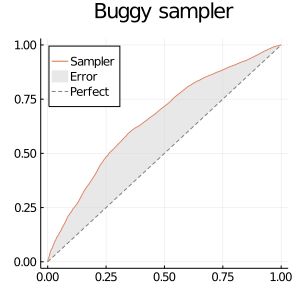

In [6]:
plot(res_buggy, BetaBinomial(); size=(300, 300), title="Buggy sampler")

You can also check the maximum mean discrepancy (MMD) using the two results.

In [7]:
@info "MMD" mmd_of(res) mmd_of(res_buggy)

┌ Info: MMD
│   mmd_of(res) = 9.005168477094205e-5
│   mmd_of(res_buggy) = 0.06918151052999455
└ @ Main In[7]:1


As you can see, the bug-free one attains a much smaller value, meaning the marginal-conditional simulator and the bug-free successive-conditional simulator admit more similar distributions.